### Preparing Spark environment to run the code

In [1]:
pip install spark

Note: you may need to restart the kernel to use updated packages.


In [2]:
import findspark
findspark.init()
from pyspark.sql import SparkSession
spark = SparkSession.builder.master("local[*]").getOrCreate()

In [3]:
from pyspark import SparkContext
sc =SparkContext.getOrCreate()

In [4]:
# Importing the libraries
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from pyspark.ml.clustering import KMeans
from pyspark.ml.evaluation import ClusteringEvaluator

In [5]:
# Loading the iris dataset
output_df = spark.read.format("csv").option("header","true").load("/Users/rashidesai/Downloads/IDS\ 561\ Big\ Data\ Analytics/Homework\ 5/iris.csv")

In [6]:
output_df.show(5)

+-----------+----------+-----------+----------+-----------+
|PetalLength|PetalWidth|SepalLength|SepalWidth|    Species|
+-----------+----------+-----------+----------+-----------+
|        5.1|       3.5|        1.4|       0.2|Iris-setosa|
|        4.9|         3|        1.4|       0.2|Iris-setosa|
|        4.7|       3.2|        1.3|       0.2|Iris-setosa|
|        4.6|       3.1|        1.5|       0.2|Iris-setosa|
|          5|       3.6|        1.4|       0.2|Iris-setosa|
+-----------+----------+-----------+----------+-----------+
only showing top 5 rows



###  Spark DataFrame Column Type Conversion using CAST
The columns in iris dataset is labeled and needs to be converted into numeric. We are using the Spark CAST method to convert data frame column data type to required Interger type format.

In [7]:
from pyspark.sql.types import IntegerType
output_df = output_df.withColumn("PetalLength",output_df["PetalLength"].cast(IntegerType()))
output_df.select("PetalLength").dtypes

[('PetalLength', 'int')]

In [8]:
output_df = output_df.withColumn("PetalWidth",output_df["PetalWidth"].cast(IntegerType()))
output_df.select("PetalWidth").dtypes

[('PetalWidth', 'int')]

In [9]:
output_df = output_df.withColumn("SepalLength",output_df["SepalLength"].cast(IntegerType()))
output_df.select("SepalLength").dtypes

[('SepalLength', 'int')]

In [10]:
output_df = output_df.withColumn("SepalWidth",output_df["SepalWidth"].cast(IntegerType()))
output_df.select("SepalWidth").dtypes

[('SepalWidth', 'int')]

In [11]:
# Print the column type for iris dataset
output_df.printSchema()

root
 |-- PetalLength: integer (nullable = true)
 |-- PetalWidth: integer (nullable = true)
 |-- SepalLength: integer (nullable = true)
 |-- SepalWidth: integer (nullable = true)
 |-- Species: string (nullable = true)



### K-means model
Next, we will use the VectorAssembler() to merge our feature columns from iris dataset into a single vector column named "features", which we will be passing into our K-means model.

In [12]:
from pyspark.ml.linalg import Vectors
from pyspark.ml.feature import VectorAssembler

# Assembler makes a vector with 4 parameters mentioned in inputCols and name it as outputCol.
assembler = VectorAssembler(inputCols = ["PetalLength", "PetalWidth", "SepalLength", "SepalWidth"], outputCol="features") 

irisFeatures = assembler.transform(output_df)

In [13]:
# Creating and training a k-means model
kmeans = KMeans().setK(3).setSeed(1)

In [14]:
model = kmeans.fit(irisFeatures)

In [15]:
# Make predictions
predictions = model.transform(irisFeatures)

### Computing Silhouette score
We are desiring a high value of Silhouette score as it indicates that the point is placed in the correct cluster.

In [16]:
# Evaluate clustering by computing Silhouette score
evaluator = ClusteringEvaluator()
silhouette = evaluator.evaluate(predictions)
print("Silhouette with k = 3 is " + str(silhouette))

Silhouette with k = 3 is 0.6972148699719254


In [17]:
# Displaying the result with cluster centers
centers = model.clusterCenters()
print("Cluster Centers: ")
for center in centers:
    print(center)

Cluster Centers: 
[5.41071429 2.30357143 3.85714286 1.01785714]
[4.6  3.04 1.   0.  ]
[6.25       2.63636364 5.22727273 1.63636364]


### Trying with 10 different values of K 

In [18]:
for k in range (2,12):
    kmeans = KMeans().setK(k).setSeed(1)
    model = kmeans.fit(irisFeatures)
    predictions = model.transform(irisFeatures)
    evaluator = ClusteringEvaluator()
    silhouette = evaluator.evaluate(predictions)
    print("Silhouette score is " + str(silhouette))

Silhouette score is 0.8293686673914576
Silhouette score is 0.6972148699719254
Silhouette score is 0.6007555692034162
Silhouette score is 0.5191843630870817
Silhouette score is 0.6305739838764371
Silhouette score is 0.4770613168940314
Silhouette score is 0.6262022640228092
Silhouette score is 0.6086876118625185
Silhouette score is 0.6106283865562345
Silhouette score is 0.7168269548497915


## k = 2 gives the best performance, Silhouette = 0.829 

### EXTRA ANALYSIS
To verify the optimal number of k for iris dataset, we can use the elbow method:

In [19]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline 
from sklearn.cluster import KMeans
from sklearn import datasets
iris = datasets.load_iris()
df = pd.DataFrame(iris['data'])

In [20]:
distortions = []
K = range(1,10)
for k in K:
    kmeanModel = KMeans(n_clusters=k)
    kmeanModel.fit(df)
    distortions.append(kmeanModel.inertia_)

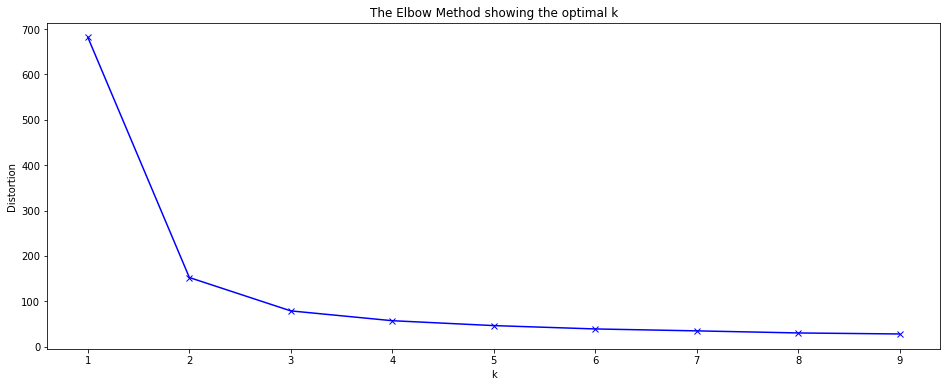

In [21]:
plt.figure(figsize=(16,6))
plt.plot(K, distortions, 'bx-')
plt.xlabel('k')
plt.ylabel('Distortion')
plt.title('The Elbow Method showing the optimal k')
plt.show()

We can observe that the “elbow” is the number 2 which is optimal for this case. Now we can run a K-Means using as number of clusters the number 2.